In [1]:
import os,sys


"""windows
# os.chdir('c:\\Work\\WORK_PACKAGE\\Demand_forecasting\\github\\DeepAR-pytorch\\My_model\\2_freq_nbinom_LSTM')
# os.getcwd()
"""

""" Linux """
os.chdir("/home/optimusprime/Desktop/peeterson/github/DeepAR_demand_prediction/2_freq_nbinom_LSTM")
!pwd

/home/optimusprime/Desktop/peeterson/github/DeepAR_demand_prediction/2_freq_nbinom_LSTM


In [2]:
#from ctypes import FormatError
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os,sys

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM')))

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data')))
# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\data\demand_data')))

import torch
torch.use_deterministic_algorithms(True)

from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_forecasting.metrics import SMAPE, RMSE
from torchmetrics import R2Score, SymmetricMeanAbsolutePercentageError, MeanSquaredError

import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import os,sys
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import operator
import statsmodels.api as sm
from itertools import combinations
import pickle
from pytorch_forecasting import Baseline
import random
from pytorch_forecasting import DeepAR,NegativeBinomialDistributionLoss
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
"""
Set Random seed
"""

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
## additional seeding to ensure reproduciblility.
pl.seed_everything(0)


"""windows
os.chdir('c:\\Work\\WORK_PACKAGE\\Demand_forecasting\\github\\DeepAR-pytorch\\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction')
"""

""" Linux"""
# os.chdir("/home/optimusprime/Desktop/peeterson/github/DeepAR_demand_prediction")
# !pwd

Global seed set to 0


' Linux'

In [4]:

encoder_len = 24
pred_len = 1 # 1, 6, 12 
#cov_lag_len= pred_len # do this when creating the dataset. import that code here.

In [5]:
"""windows
os.chdir('c:\\Work\\WORK_PACKAGE\\Demand_forecasting\\github\\DeepAR-pytorch\\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\\data\\demand_data')
"""

""" Linux """
os.chdir("/home/optimusprime/Desktop/peeterson/github/DeepAR_demand_prediction/2_freq_nbinom_LSTM/1_cluster_demand_prediction/data/demand_data/New_BlueSG_clusters")
!pwd


/home/optimusprime/Desktop/peeterson/github/DeepAR_demand_prediction/2_freq_nbinom_LSTM/1_cluster_demand_prediction/data/demand_data/New_BlueSG_clusters


In [6]:
tampines_all_clstr_train_dem_data = pd.read_csv('tampines_all_clstr_train_dem_data.csv')
tampines_all_clstr_val_dem_data = pd.read_csv('tampines_all_clstr_val_dem_data.csv')
tampines_all_clstr_test_dem_data = pd.read_csv('tampines_all_clstr_test_dem_data.csv')

tampines_all_clstr_train_dem_data = tampines_all_clstr_train_dem_data.drop(['Unnamed: 0'],axis=1)
tampines_all_clstr_val_dem_data = tampines_all_clstr_val_dem_data.drop(['Unnamed: 0'],axis=1)
tampines_all_clstr_test_dem_data = tampines_all_clstr_test_dem_data.drop(['Unnamed: 0'],axis=1)



train_data = tampines_all_clstr_train_dem_data
val_data = tampines_all_clstr_val_dem_data
test_data = tampines_all_clstr_test_dem_data

# cov_lag_len = 0

# # dont adjsut b
# for c in tampines_all_clstr_train_dem_data.columns:
    
#     if c == 'target':  
#         target_train = tampines_all_clstr_train_dem_data[c].iloc[:]
#         train_data[c] = target_train.reset_index(drop=True)
#         target_val = tampines_all_clstr_val_dem_data[c].iloc[:]
#         val_data[c] = target_val.reset_index(drop=True)
#         target_test = tampines_all_clstr_test_dem_data[c].iloc[:]
#         test_data[c] = target_test.reset_index(drop=True)

#     else:
#         other_col_train = tampines_all_clstr_train_dem_data[c].iloc[:]
#         train_data[c] = other_col_train.reset_index(drop=True)
#         other_col_val = tampines_all_clstr_val_dem_data[c].iloc[:]
#         val_data[c] = other_col_val.reset_index(drop=True)
#         other_col_test = tampines_all_clstr_test_dem_data[c].iloc[:]
#         test_data[c] = other_col_test.reset_index(drop=True)



In [8]:
"""
Import pre-processed Data
"""
#################### add date information ts ####################
#2021 oct 17 20:00:00

cov_lag_len = 1

day=17
hour=(20+cov_lag_len)
if (20+cov_lag_len)>23:
  day = 18
  hour = hour%24

train_data["date"] = pd.Timestamp(year=2021, month=10, day=day, hour=hour ) + pd.to_timedelta(train_data.time_idx, "H")
train_data['_hour_of_day'] = train_data["date"].dt.hour.astype(str)
train_data['_day_of_week'] = train_data["date"].dt.dayofweek.astype(str)
train_data['_day_of_month'] = train_data["date"].dt.day.astype(str)
train_data['_day_of_year'] = train_data["date"].dt.dayofyear.astype(str)
train_data['_week_of_year'] = train_data["date"].dt.weekofyear.astype(str)
train_data['_month_of_year'] = train_data["date"].dt.month.astype(str)
train_data['_year'] = train_data["date"].dt.year.astype(str)
#################### add date information ts ####################


#################### add date information ts ####################
# val starts at 3/12/2021 09:00
day=3
hour=(9+cov_lag_len)
if (9+cov_lag_len)>23:
  day = 4
  hour = hour%24

val_data["date"] = pd.Timestamp(year=2021, month=12, day=day, hour=hour ) + pd.to_timedelta(val_data.time_idx, "H")
val_data['_hour_of_day'] = val_data["date"].dt.hour.astype(str)
val_data['_day_of_week'] = val_data["date"].dt.dayofweek.astype(str)
val_data['_day_of_month'] = val_data["date"].dt.day.astype(str)
val_data['_day_of_year'] = val_data["date"].dt.dayofyear.astype(str)
val_data['_week_of_year'] = val_data["date"].dt.weekofyear.astype(str)
val_data['_month_of_year'] = val_data["date"].dt.month.astype(str)
val_data['_year'] = val_data["date"].dt.year.astype(str)
#################### add date information ts ####################


#################### add date information ts ####################
# test starts at 16/12/2021 16:00
day=16
hour=(16+cov_lag_len)
if (16+cov_lag_len)>23:
  day = 17
  hour = hour%24

test_data["date"] = pd.Timestamp(year=2021, month=12, day=day, hour=hour ) + pd.to_timedelta(test_data.time_idx, "H")
test_data['_hour_of_day'] = test_data["date"].dt.hour.astype(str)
test_data['_day_of_week'] = test_data["date"].dt.dayofweek.astype(str)
test_data['_day_of_month'] = test_data["date"].dt.day.astype(str)
test_data['_day_of_year'] = test_data["date"].dt.dayofyear.astype(str)
test_data['_week_of_year'] = test_data["date"].dt.weekofyear.astype(str)
test_data['_month_of_year'] = test_data["date"].dt.month.astype(str)
test_data['_year'] = test_data["date"].dt.year.astype(str)
#################### add date information ts ####################

Target = 'target'


In [9]:
print(list(train_data.columns))

['time_idx', 'target', 'group', 'inflow', 'dem_lag_168', 'dem_lag_336', 'inf_lag_168', 'inf_lag_336', 'date', '_hour_of_day', '_day_of_week', '_day_of_month', '_day_of_year', '_week_of_year', '_month_of_year', '_year']


In [10]:
# cov = list(df6.columns)
# cov = cov[:-6] # remove one extra covariate to reduce hyperparam comb. However, these are added again below for every hparams comb.
# print(cov)

# cov_pairs_list = []
# for p in combinations(cov,2):
#   cov_pairs_list.append(p)

In [11]:
# cov_pairs_list

In [12]:
"""
set inputs here
(hyperparameters grid search)

"""
######### Network Architecture ###################


###### Create hyperparameters grid ###### 

hparams_grid = {"LSTM_neuron_size":[660],
	            "num_layers":[1],
                "batch_size":[8],
                "learning_rate":[0.00006],
                "max_encoder_length":[encoder_len],
                "max_prediction_length":[pred_len],
                "dropout":[0.2],
                #"cov_pair":cov_pairs_list,# [cov_pairs_list[7]],
                "Num_epochs":[1]}#[18,20,22,24,26,28,30]}
	            #"Num_epochs":[16,18,20,22,24,26,28]}
###### Create hyperparameters grid ###### 

p = 10 # patience no. of epochs

Loss=NegativeBinomialDistributionLoss()

######### Network Architecture ###################
 



######### Training Routine ###################
fdv_steps = 10 # fast_dev_run
######### Training Routine ###################


############## Inputs for 2) Persistance model ( seasonal naive forecast ) #######################
season_len = 168 # length of season
num_past_seas = 2 # number of past seasons to use in averaging
#seas_pred_strt_idx = 2035 # seasonal naive forecast start index, in hours use the df dataframe
############## Inputs for 2) Persistance model ( seasonal naive forecast ) #######################


param_comb_cnt=0
for neu,lay,bat,lr,enc_len,pred_len,drop,num_ep in product(*[x for x in hparams_grid.values()]):
    print(param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep)
    param_comb_cnt+=1
param_comb_cnt

0 84 1 16 0.001 24 1 0 1


1

In [13]:
"""
Data loading sanity check

""" 

# ###### View the entire data using this code ##################
# print(train_dataset.data['categoricals'])
# ###### View the data entire using this code ##################

# ####### View the data for each batch using this code ##################
# i=0
# for x,y in iter(test_dataloader):
#     #print(x["encoder_cat"][0][0:72,2])
#     print(train_dataset.x_to_index(x))
#     #print(test_data['time_idx'].iloc[i+24:i+24+4])
#     i+=4
#     #break
# print(i)
# ####### View the data for each batch using this code ##################


'\nData loading sanity check\n\n'

In [14]:
"""
Full Training Routine 
with hyperparmeter grid search

Load data into TimeSeriesDataSet object

for fast development run
uncomment fast_dev_run = fdv_steps

"""

#early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=p, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

RMSE_list = [] # FIND minimum RMSE case
hyperparams_list = [] # FIND minimum RMSE case

# best_val_comb_idx=[17,21,51,52,53,54,61,62,63,82,83,84,109,110,111,143,144,145,195,218,219,220,232,233,234,236,237,238,280,338,339,340,344,345,346,386]
# best_val_train_epochs = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

# best_val_comb_idx=[234]
# best_val_train_epochs = [50]
num_cols_list = []

cat_dict = {"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(train_data._hour_of_day), \
"_day_of_week": NaNLabelEncoder(add_nan=True).fit(train_data._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(train_data._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(train_data._day_of_year), \
    "_week_of_year": NaNLabelEncoder(add_nan=True).fit(train_data._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(train_data._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(train_data._year) }
cat_list = ["_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]  

num_cols_list.append('dem_lag_168') 
num_cols_list.append('dem_lag_336')
num_cols_list.append('inflow')
# num_cols_list.append('inf_lag_168')  
# num_cols_list.append('inf_lag_336')

# param_comb_cnt=-1
for neu,lay,bat,lr,enc_len,pred_len,drop,num_ep in product(*[x for x in hparams_grid.values()]):
    
#   param_comb_cnt+=1
#   if param_comb_cnt <0 or param_comb_cnt > 50:
#     continue

  # df_cov_col1 = cov_pair[0]
  # df_cov_col2 = cov_pair[1]

    ######### Load DATA #############

  #cat_list.append('wea_desc_clstr_52')

  train_dataset = TimeSeriesDataSet(
      train_data,
      time_idx="time_idx",
      target=Target,
      categorical_encoders=cat_dict,
      group_ids=["group"],
      min_encoder_length=enc_len,
      max_encoder_length=enc_len,
      min_prediction_length=pred_len,
      max_prediction_length=pred_len,
      time_varying_unknown_reals=[Target],
      time_varying_known_reals=num_cols_list,
      time_varying_known_categoricals=cat_list,
      add_relative_time_idx=False,
      randomize_length=False,
      scalers={},
      target_normalizer=TorchNormalizer(method="identity",center=False,transformation=None )

  )

  val_dataset = TimeSeriesDataSet.from_dataset(train_dataset,val_data, stop_randomization=True, predict=False)
  test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,test_data, stop_randomization=True)

  train_dataloader = train_dataset.to_dataloader(train=True, )
  val_dataloader = val_dataset.to_dataloader(train=False,  )
  test_dataloader = test_dataset.to_dataloader(train=False, )
  ######### Load DATA #############


  """
  Machine Learning predictions START
  1) DeepAR

  """
  trainer = pl.Trainer(
      max_epochs=num_ep,
      gpus=-1, #-1
      auto_lr_find=False,
      gradient_clip_val=0.1,
      limit_train_batches=1.0,
      limit_val_batches=1.0,
      #fast_dev_run=fdv_steps,
      logger=True,
      #log_every_n_steps=10,
      # profiler=True,
      callbacks=[lr_logger]#, early_stop_callback],
      #enable_checkpointing=True,
      #default_root_dir="C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\logs"
  )


  #print(f"training routing:\n \n {trainer}")
  deepar = DeepAR.from_dataset(
      train_dataset,
      learning_rate=lr,
      hidden_size=neu,
      rnn_layers=lay,
      dropout=drop,
      loss=Loss,
      log_interval=20,
      log_val_interval=6,
      log_gradient_flow=False,
      # reduce_on_plateau_patience=3,
  )

    
  #print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")
  # print(f"Model :\n \n {deepar}")
  #torch.set_num_threads(10)
  trainer.fit(
      deepar,
      train_dataloaders=train_dataloader,
      val_dataloaders=val_dataloader,
  )

  ########## Prediction #####################

  test_output = deepar.predict(data=test_dataloader,mode='prediction',return_index=True,num_workers=8,show_progress_bar=True)

  len1 = test_output[1]['time_idx'].shape[0]

  actual1_full = np.array([])
  pred_full = np.array([])  
  RMSE_list = np.array([])

  old_pred_idx = test_output[1]['time_idx'][0]

  group = 0
  for i in range(len1):
      pred_idx = test_output[1]['time_idx'][i]
      if pred_idx - old_pred_idx > 1: # moved into new group
          print('group ',group)
          plt.figure(figsize=(25,5))
          plt.plot(actual1_full.flatten(),'^-')
          plt.plot(pred_full.flatten(),'*-')
          plt.show()
          RMSE = np.sqrt(mean_squared_error(actual1_full.flatten(),pred_full.flatten() ))
          print('RMSE : ', RMSE)

          plt.title('scatter plot')
          plt.xlabel('actual')
          plt.ylabel('prediction')            
          plt.scatter(actual1_full.flatten(),pred_full.flatten() )
          plt.show()

          actual1_full = np.array([])
          pred_full = np.array([])
          group+=1


      actual = test_data[Target].iloc[pred_idx:pred_idx+pred_len].values
      actual1_full = np.append(actual1_full, actual)

      pred = np.array(np.rint(test_output[0][i])).astype(int)
      pred_full = np.append(pred_full, pred)
      old_pred_idx = pred_idx
      i=i+pred_len

  plt.figure(figsize=(25,5))
  plt.plot(actual1_full.flatten(),'^-')
  plt.plot(pred_full.flatten(),'*-')
  plt.show()
  plt.title('scatter plot')
  plt.xlabel('actual')
  plt.ylabel('prediction')       
  plt.scatter(actual1_full.flatten(),pred_full.flatten() )
  plt.show()
  RMSE = np.sqrt(mean_squared_error(actual1_full.flatten(),pred_full.flatten() ))
  print('RMSE : ', RMSE)

  print('\n Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,inflow\n')
  print(param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,' \n')
  ########## Prediction #####################
    
  # TO find minimum RMSE
  hyperparams_list.append((neu,lay,bat,lr,enc_len,pred_len,drop,num_ep))
  # RMSE_list.append(RMSE)

  

  """
  Machine Learning predictions END
  """

######## Identify least RMSE case #############
# min_RMSE_idx = RMSE_list.index(min(RMSE_list))
# hyperparams_list[min_RMSE_idx]

######## Identify least RMSE case #############





KeyError: "Unknown category 'nan' encountered. Set `add_nan=True` to allow unknown categories"

In [ ]:
"""
Data loading sanity check

""" 

######## View the entire data using this code ##################
#print(train_dataset.data['categoricals'])
######## View the data entire using this code ##################

# ######## View the data for each batch using this code ##################
# i=0
# for x,y in iter(val_dataloader):
#     #print(x["encoder_cat"][0][0:72,2])
#     # if i < 500:
#     #     print(test_dataset.x_to_index(x))
#     print(x)
#     #print(test_data['time_idx'].iloc[i+24:i+24+4])
#     i+=bat
#     #break
# print(i)
# ######## View the data for each batch using this code ##################

'\nData loading sanity check\n\n'

In [ ]:
"""
DeepAR prediction.

"""


# len1 = test_output[1]['time_idx'].shape[0]

# actual1_full = np.array([])
# pred_full = np.array([])  
# RMSE_list = np.array([])

# old_pred_idx = test_output[1]['time_idx'][0]

# for i in range(len1):
#     pred_idx = test_output[1]['time_idx'][i]
#     if pred_idx - old_pred_idx > 1: # moved into new group
#         plt.figure(figsize=(25,5))
#         plt.plot(actual1_full.flatten(),'^-')
#         plt.plot(pred_full.flatten(),'*-')
#         plt.show()
#         RMSE = np.sqrt(mean_squared_error(actual1_full.flatten(),pred_full.flatten() ))
#         print('Average RMSE : ', RMSE)
#         actual1_full = np.array([])
#         pred_full = np.array([])

#     actual = test_data[Target].iloc[pred_idx:pred_idx+pred_len].values
#     actual1_full = np.append(actual1_full, actual)

#     pred = np.array(np.rint(test_output[0][i])).astype(int)
#     pred_full = np.append(pred_full, pred)
#     old_pred_idx = pred_idx
#     i=i+pred_len

# plt.figure(figsize=(25,5))
# plt.plot(actual1_full.flatten(),'^-')
# plt.plot(pred_full.flatten(),'*-')
# plt.show()
# RMSE = np.sqrt(mean_squared_error(actual1_full.flatten(),pred_full.flatten() ))
# print('Average RMSE : ', RMSE)


'\nDeepAR prediction.\n\n'

group  0


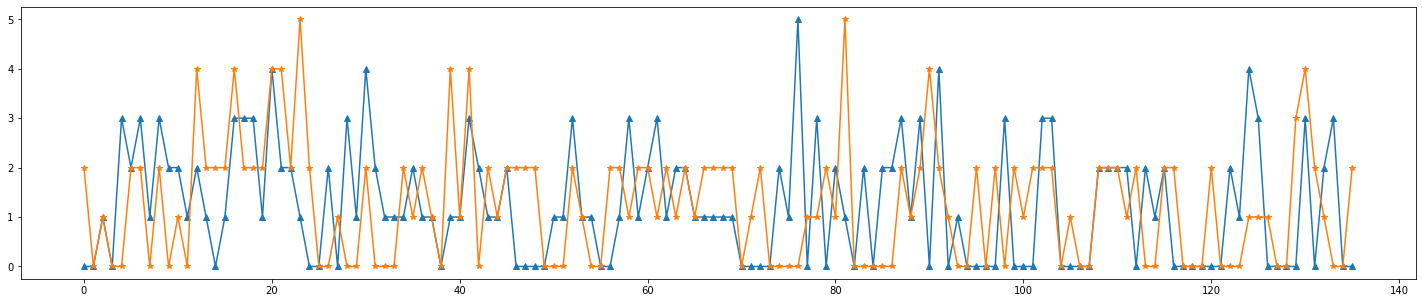

RMSE :  1.557713256101807


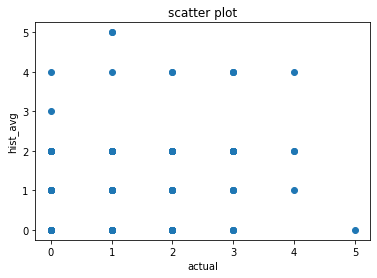

group  1


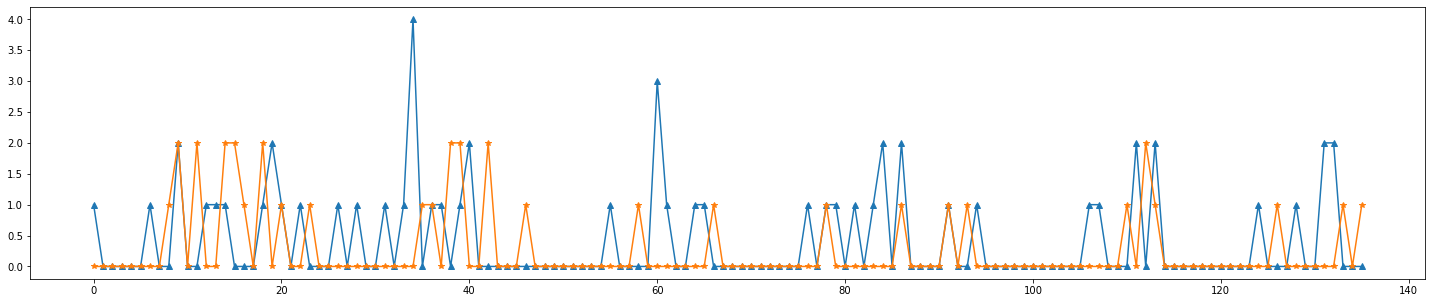

RMSE :  0.8952488973661427


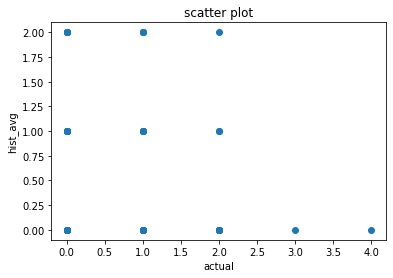

group  2


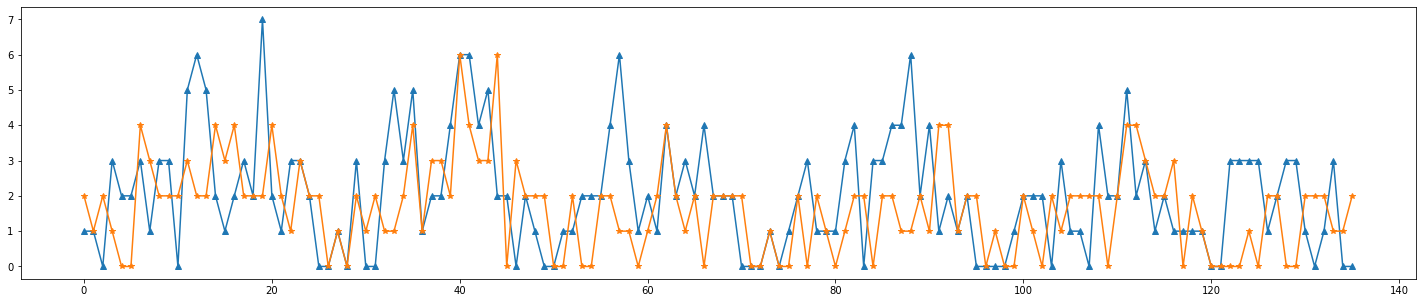

RMSE :  1.8371173070873836


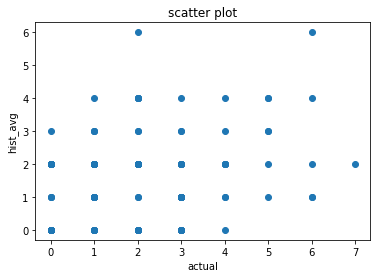

group  3


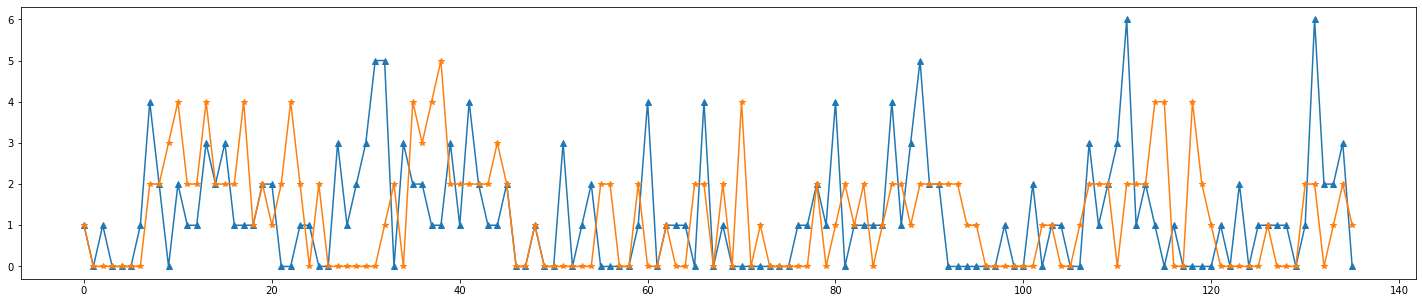

RMSE :  1.7278003697322961


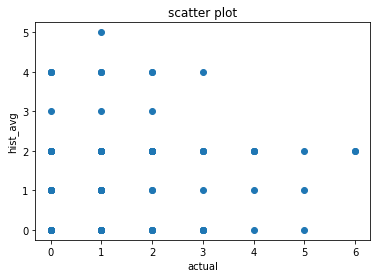

group  4


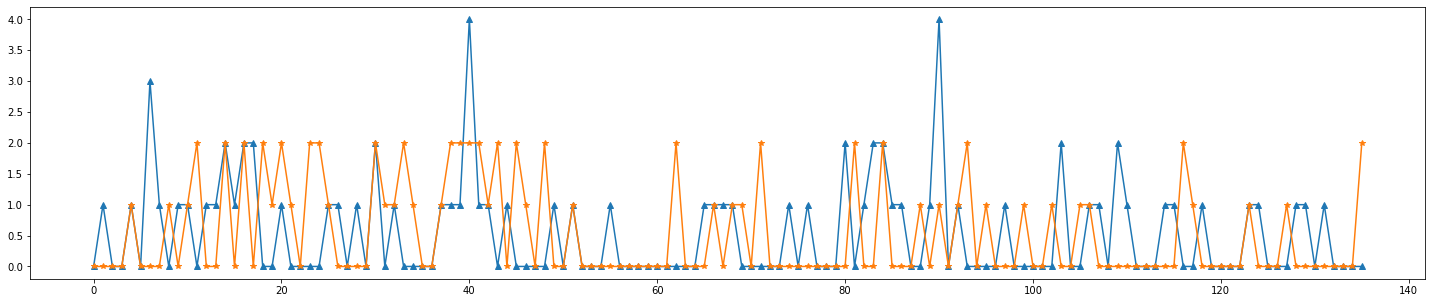

RMSE :  1.0325582165612917


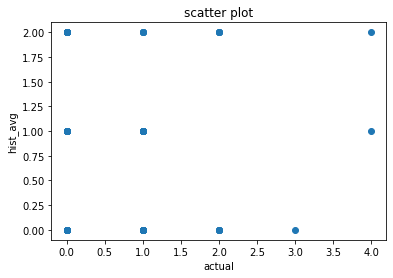

group  5


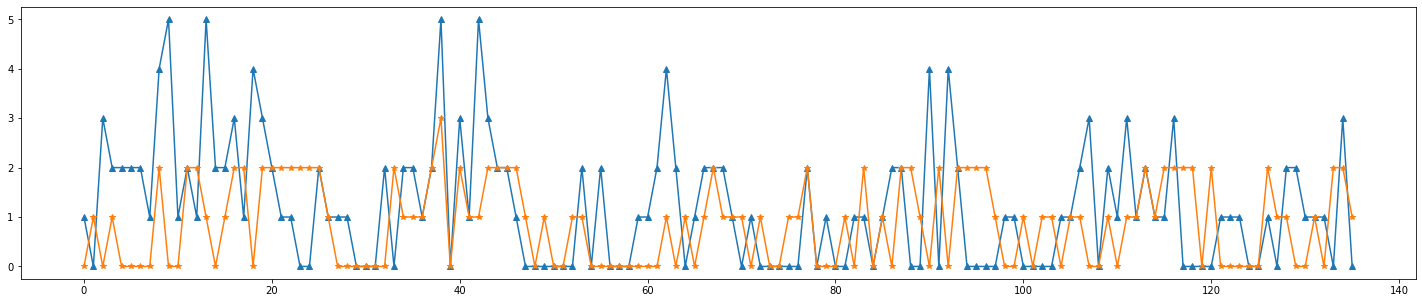

RMSE :  1.4677914581799016


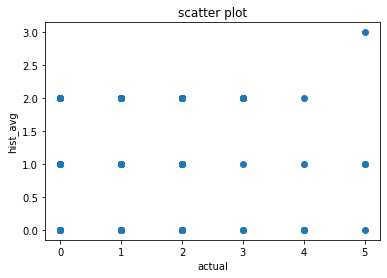

group  6


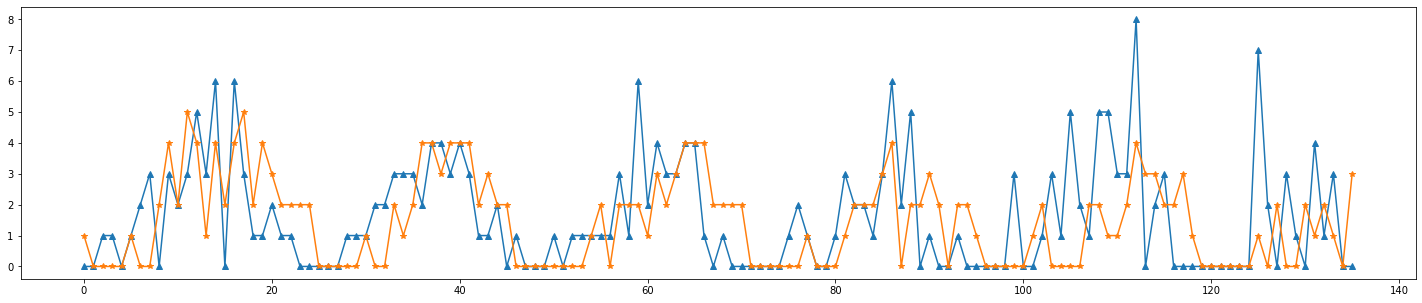

RMSE :  1.708542550555538


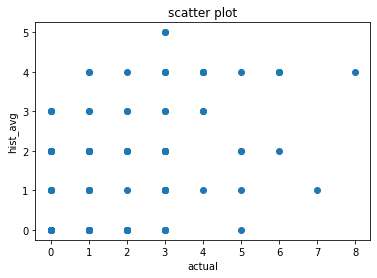

group  7


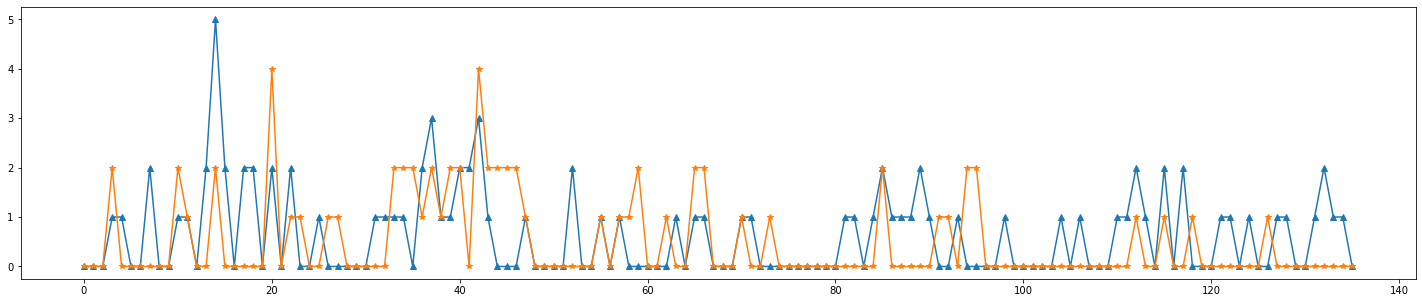

RMSE :  0.9889090840267311


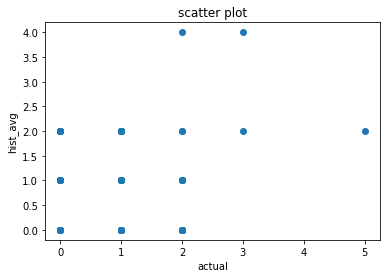

group  8


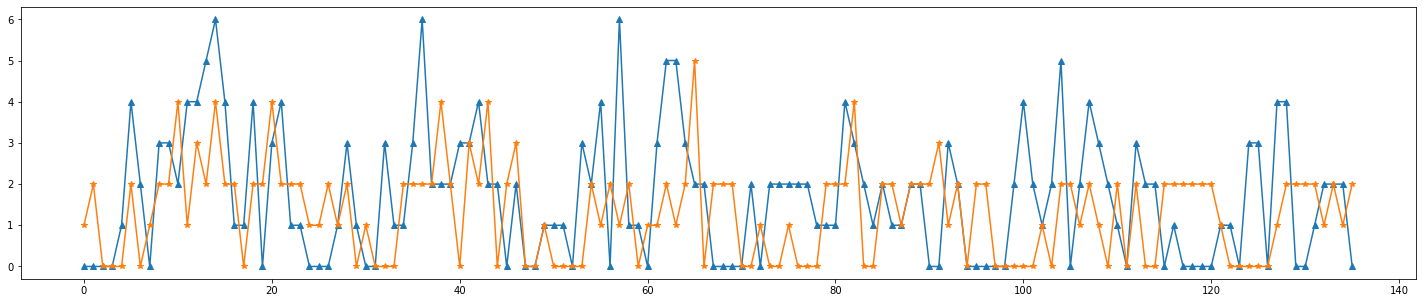

RMSE :  1.7822655773580136


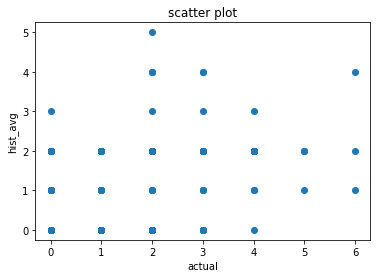

group  9


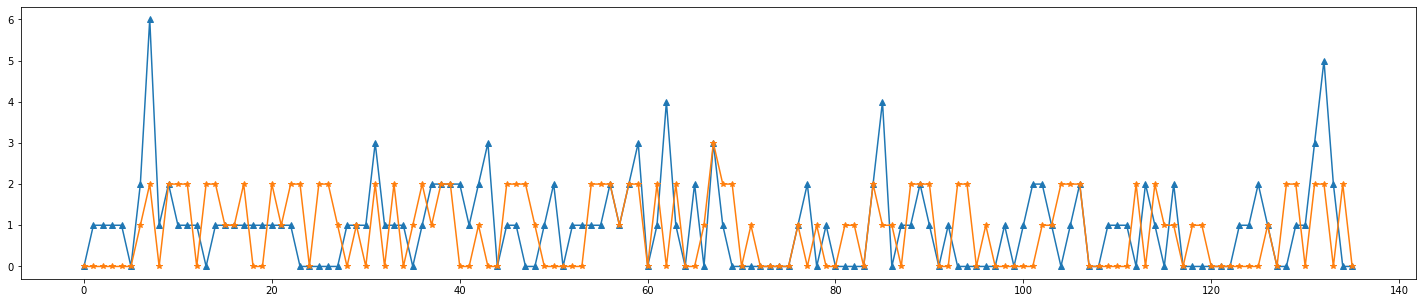

RMSE :  1.2337174812449614


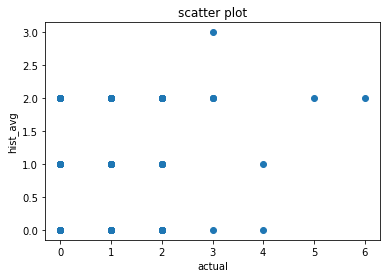

group  10


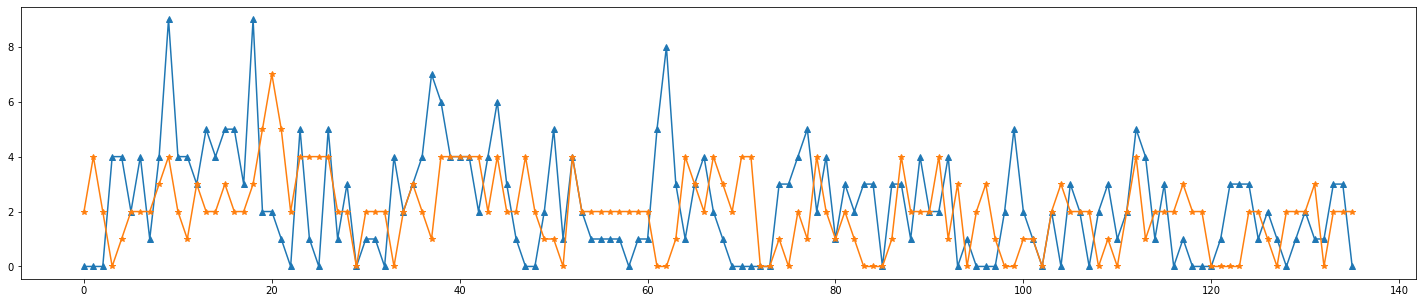

 RMSE :  2.3405001979215014

 Average RMSE =  1.506560399648688


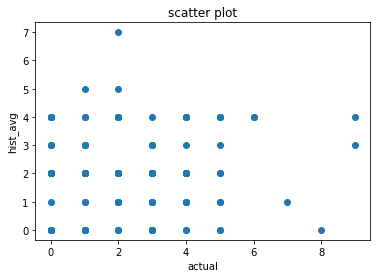

In [ ]:

"""

Historic average prediction.

"""

len1 = test_output[1]['time_idx'].shape[0]
actual1_full = np.array([])
hist_avg_full = np.array([])
RMSE_list = np.array([])

old_pred_idx = test_output[1]['time_idx'][0]

group = 0
for i in range(len1):
    pred_idx = test_output[1]['time_idx'][i]
    if pred_idx - old_pred_idx > 1: # moved into new group
        print('group ',group)
        plt.figure(figsize=(25,5))
        plt.plot(actual1_full.flatten(),'^-')
        plt.plot(hist_avg_full.flatten(),'*-')
        plt.show()
        RMSE = np.sqrt(mean_squared_error(actual1_full.flatten(),hist_avg_full.flatten() ))
        print('RMSE : ', RMSE)
        RMSE_list = np.append(RMSE_list,RMSE)

        plt.title('scatter plot')
        plt.xlabel('actual')
        plt.ylabel('hist_avg')
        plt.scatter(actual1_full.flatten(),hist_avg_full.flatten() )
        plt.show()

        actual1_full = np.array([])
        hist_avg_full = np.array([])
        group+=1



    actual = test_data[Target].iloc[pred_idx:pred_idx+pred_len].values
    actual1_full = np.append(actual1_full, actual)

    strt_idx = val_data.index[val_data['group'] == group][-1] - season_len + encoder_len
    idx = strt_idx

    hist_avg_full = np.array([])

    while(idx < ( int(len(test_data)/(test_data['group'].nunique())) + strt_idx - encoder_len) ):
        hist_avg = np.array([])
        for h in range(pred_len):
            sum1 = 0
            for n in range(num_past_seas):
                o=4 if n%2==0 else 1
                sum1 = sum1 + val_data[Target][idx-o+h - season_len*n]

            hist_avg = np.append(hist_avg,np.rint(sum1/num_past_seas))
            #print(len(hist_avg))

        hist_avg_full = np.append(hist_avg_full, hist_avg)
        #print(len(hist_avg_full))
        idx+=pred_len

    old_pred_idx = pred_idx
    i=i+pred_len

print('group ',group)
plt.figure(figsize=(25,5))
plt.plot(actual1_full.flatten(),'^-')
plt.plot(hist_avg_full.flatten(),'*-')
plt.show()
RMSE = np.sqrt(mean_squared_error(actual1_full.flatten(),hist_avg_full.flatten() ))
print(' RMSE : ', RMSE)
RMSE_list = np.append(RMSE_list,RMSE)
print('\n Average RMSE = ',np.mean(RMSE_list))

plt.title('scatter plot')
plt.xlabel('actual')
plt.ylabel('hist_avg')
plt.scatter(actual1_full.flatten(),hist_avg_full.flatten() )
plt.show()


In [ ]:
train_data

,time_idx,target,group,inflow,dem_lag_168,dem_lag_336,inf_lag_168,inf_lag_336,date,_hour_of_day,_day_of_week,_day_of_month,_day_of_year,_week_of_year,_month_of_year,_year
0,0,1,0,1,0,1,2,0,2021-10-17 21:00:00,21,6,17,290,41,10,2021
1,1,2,0,2,0,0,0,1,2021-10-17 22:00:00,22,6,17,290,41,10,2021
2,2,2,0,1,2,2,0,0,2021-10-17 23:00:00,23,6,17,290,41,10,2021
3,3,0,0,3,0,0,0,1,2021-10-18 00:00:00,0,0,18,291,42,10,2021
4,4,2,0,1,3,1,1,1,2021-10-18 01:00:00,1,0,18,291,42,10,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12271,12271,2,10,2,4,1,4,1,2023-03-13 04:00:00,4,0,13,72,11,3,2023
12272,12272,4,10,2,3,9,1,4,2023-03-13 05:00:00,5,0,13,72,11,3,2023
12273,12273,5,10,4,2,7,3,7,2023-03-13 06:00:00,6,0,13,72,11,3,2023
12274,12274,4,10,4,5,3,4,4,2023-03-13 07:00:00,7,0,13,72,11,3,2023
